In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Sentimental Analysis

Will use 2 main approaches to sentimental analysis
- VADER (Valence Aware Dictionary sEntiment Reasoner) - Bag of words approach
- ROBERTA (Transformer) by 🤗

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [3]:
import nltk

In [4]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv', index_col='Id')

In [5]:
df

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...
568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."


In [6]:
df.Text.iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
df.shape

(568454, 9)

In [8]:
df_subset = df.head(500)

# EDA

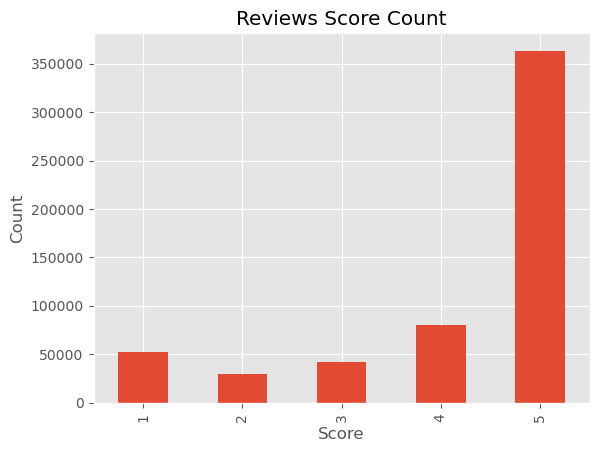

In [9]:
df.Score.value_counts().sort_index().plot(kind='bar', title='Reviews Score Count')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

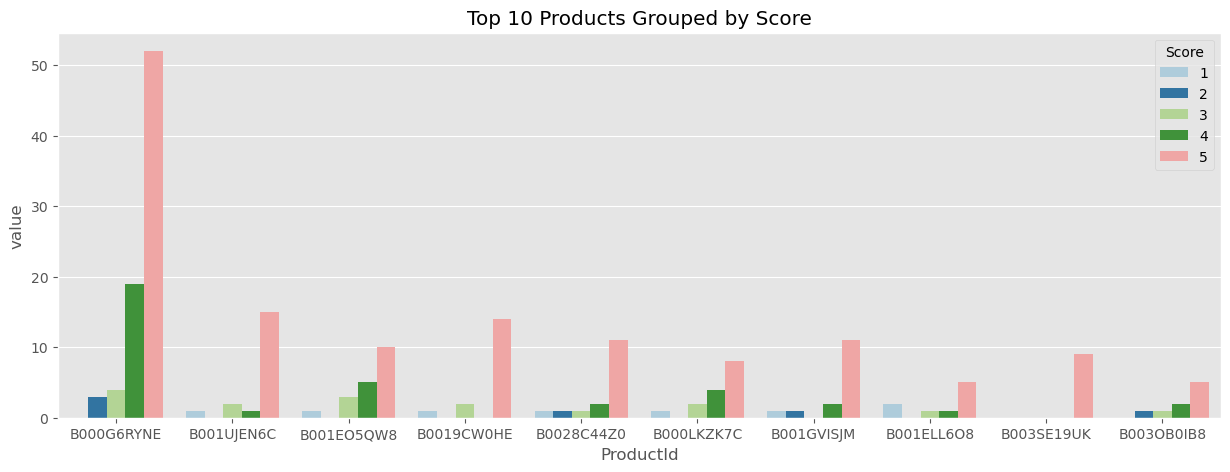

In [10]:
# ProductId and Count of Score type
temp = df_subset.groupby(['ProductId', 'Score']).aggregate({"Score": "count"})
temp.columns = ['count']
temp.reset_index(inplace=True)

# for sorting
tempmask = df_subset.groupby(['ProductId'])['ProductId'].count()

# Top 10 Products by count
top10_Products = tempmask.sort_values(ascending=False).head(10).index

# Retrieve Top 10 Products
temp['TotalCount'] = temp['ProductId'].map(tempmask)
temp.sort_values('TotalCount', ascending=False, inplace=True)
toptemp = temp[temp['ProductId'].isin(top10_Products)].drop('TotalCount', axis=1)

# Grouped Bar plot
plt.figure(figsize=(15,5))
sns.barplot(x='ProductId', y='value', hue='Score', data=pd.melt(toptemp, id_vars=['ProductId', 'Score']), palette='Paired')
plt.title('Top 10 Products Grouped by Score')
plt.show()

**Top 10 Products**
- Most of the products are dominated by higher score of 5
- Product B001ELL608 has the highest frequency of 1-scored reviews

# NLTK (Python Natural Language Toolkit)

In [11]:
example = df_subset.Text.iloc[50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

### Tokenize

In [12]:
ex_token = nltk.word_tokenize(example)
np.array(ex_token)

array(['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',',
       'soft', ',', 'I', 'do', "n't", 'like', 'it', '.', 'Quaker', 'Oats',
       'is', 'the', 'way', 'to', 'go', '.'], dtype='<U7')

**The tokenizer is not just split the words by spaces, instead it is extracts real words. Ex: "don't" >> "do", "n't"**

## Stop-words

In [13]:
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))
filtered_sentence = [word for word in ex_token if not word.lower() in stop_words]
filtered_sentence

['oatmeal',
 'good',
 '.',
 'mushy',
 ',',
 'soft',
 ',',
 "n't",
 'like',
 '.',
 'Quaker',
 'Oats',
 'way',
 'go',
 '.']

### Part Of Speech

In [14]:
ex_tagged = nltk.pos_tag(ex_token)
ex_tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

ref: https://www.educba.com/nltk-pos-tag/

In [15]:
ex_chunked = nltk.chunk.ne_chunk(ex_tagged)
ex_chunked.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# VADER Sentiment scoring

We'll use NLTK's `SentimentIntensityAnalyzer` to get the positive/negative/neutral scores of a text

- Uses Bag of words:
    - Stop words are removed
    - Each word is stored and combined for a final score
    
Remember it will score each word individually and then combines the scoring to check wheather the statement is positive or otherwise. Becuase of independent scoring, it does not take into account the relationship between words (context)

In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [17]:
# Get scores of sentences
print(sia.polarity_scores("I have a happy and hugging face!"))
print(sia.polarity_scores("This couldn't be more awful"))
print(sia.polarity_scores("The product is good but couldn't have been better"))

{'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'compound': 0.7777}
{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.4013}
{'neg': 0.258, 'neu': 0.58, 'pos': 0.162, 'compound': -0.2867}


**The above statements is more of a;**
- positive 
- negative 
- neutral 
<br>
sentiment resp. (compound shows overall score in range -1 to +1)

In [18]:
print(example)
ex_score = sia.polarity_scores(example)
ex_score

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
# Get scores for entire dataset
from tqdm.notebook import tqdm # for a beautiful progress bar

result_score = {}
for i, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    result_score[i] = sia.polarity_scores(row['Text'])

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(result_score).T
vaders.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.079,0.853,0.068,-0.1027
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [21]:
# Merge to original dataset
df_vader = df_subset.merge(vaders, how='left', left_index=True, right_index=True)
df_vader.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neg,neu,pos,compound
Id,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.695,0.305,0.9441
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.079,0.853,0.068,-0.1027
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.091,0.754,0.155,0.8265
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,1.000,0.000,0.0000
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.552,0.448,0.9468


# Plot Vader

If we assume the Review Score of 5 is more like positive sentiment than negative, we want the Compound score also to be higher. <br>
**low Score has lower Compound and Higher Score has higher Compound**

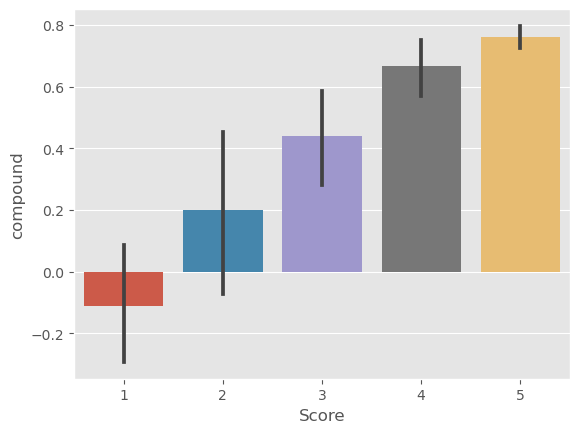

In [22]:
sns.barplot(data=df_vader, x='Score', y='compound', label='Compound score by Review Score')
plt.show()

We can see it is inline with our assumption

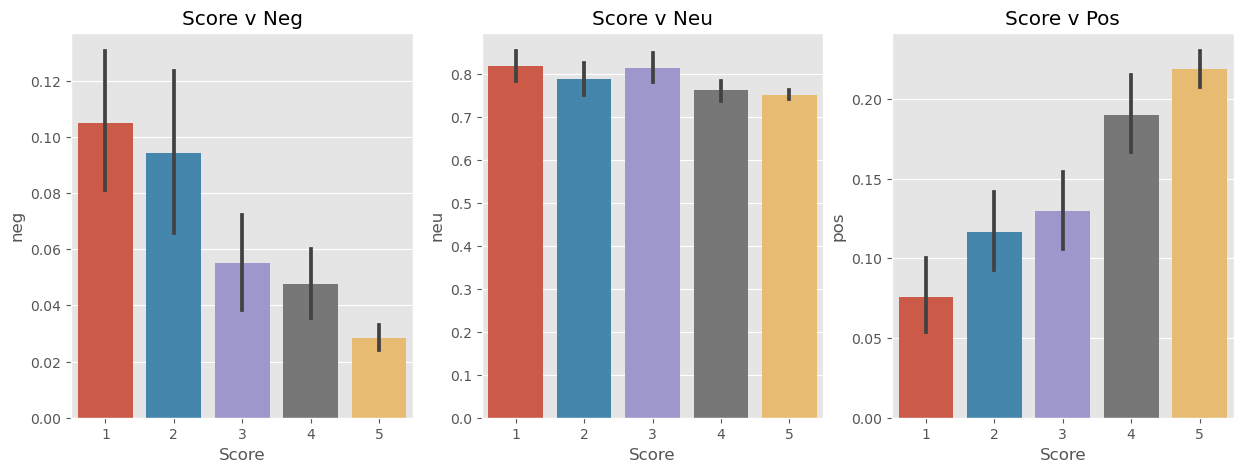

In [23]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=df_vader, x='Score', y='neg', ax=axs[0])
sns.barplot(data=df_vader, x='Score', y='neu', ax=axs[1])
sns.barplot(data=df_vader, x='Score', y='pos', ax=axs[2])

axs[0].set_title('Score v Neg')
axs[1].set_title('Score v Neu')
axs[2].set_title('Score v Pos')
plt.show()

In [24]:
sia.polarity_scores('You should cut yourself some slack')

{'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'compound': -0.2732}

# Roberta - Pretrained Model

- Roberta is a Transformer
- Trained on Large corpus of data
- Transformer models not only account for words, but also for the context of a statement

In [25]:
from transformers import AutoTokenizer # for tokenizing 
from transformers import AutoModelForSequenceClassification # for classification
from scipy.special import softmax # for normalizing the output

In [26]:
# Compile Pre-Trained Model
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
# Encode text
encoded_text = tokenizer(example, return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0,   713,  1021, 38615,    16,    45,   205,     4,  3139, 39589,
           219,     6,  3793,     6,    38,   218,    75,   101,    24,     4,
          3232,  4218,   384,  2923,    16,     5,   169,     7,   213,     4,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [28]:
# Run the model
ex_score_roberta = model(**encoded_text)
ex_score_roberta

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [29]:
# Apply softmax
ex_score_roberta = ex_score_roberta[0][0].detach().numpy()
ex_score_roberta = softmax(ex_score_roberta)
ex_score_roberta = {
    'roberta_neg': ex_score_roberta[0],
    'roberta_neu': ex_score_roberta[1],
    'roberta_pos': ex_score_roberta[2],
}
ex_score_roberta

{'roberta_neg': 0.9763551,
 'roberta_neu': 0.020687481,
 'roberta_pos': 0.0029573701}

In [30]:
print(example)
print('Score by VADER:', ex_score)
print('Score by Roberta:', ex_score_roberta )

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Score by VADER: {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}
Score by Roberta: {'roberta_neg': 0.9763551, 'roberta_neu': 0.020687481, 'roberta_pos': 0.0029573701}


### **<font color='Green'> We can see Roberta accounts for context and is much more powerful than simple models like VADER </font>**

# Final Model Combine

In [31]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    score = model(**encoded_text)
    score = score[0][0].detach().numpy()
    score = softmax(score)
    score = {
        'roberta_neg': score[0],
        'roberta_neu': score[1],
        'roberta_pos': score[2],
    }
    return score

In [32]:
result_score = {}
for i, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    try:
        # VADER
        vader_score = sia.polarity_scores(row['Text'])
        new_vader_score = {}
        for key, value in vader_score.items():
            new_vader_score[f"vader_{key}"] = value
        # Roberta
        roberta_score = polarity_scores_roberta(row['Text'])
        combine_score = {**new_vader_score, **roberta_score}
        result_score[i] = combine_score
    except:
        print(f"Broke for Id {i} - can't be handled by Roberta")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for Id 83 - can't be handled by Roberta
Broke for Id 187 - can't be handled by Roberta


In [33]:
# Join DataFrame with Scores
result_df = pd.DataFrame(result_score).T
final_df = df_subset.merge(result_df, how='left', left_index=True, right_index=True)
final_df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
Id,,,,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063


# Inferences

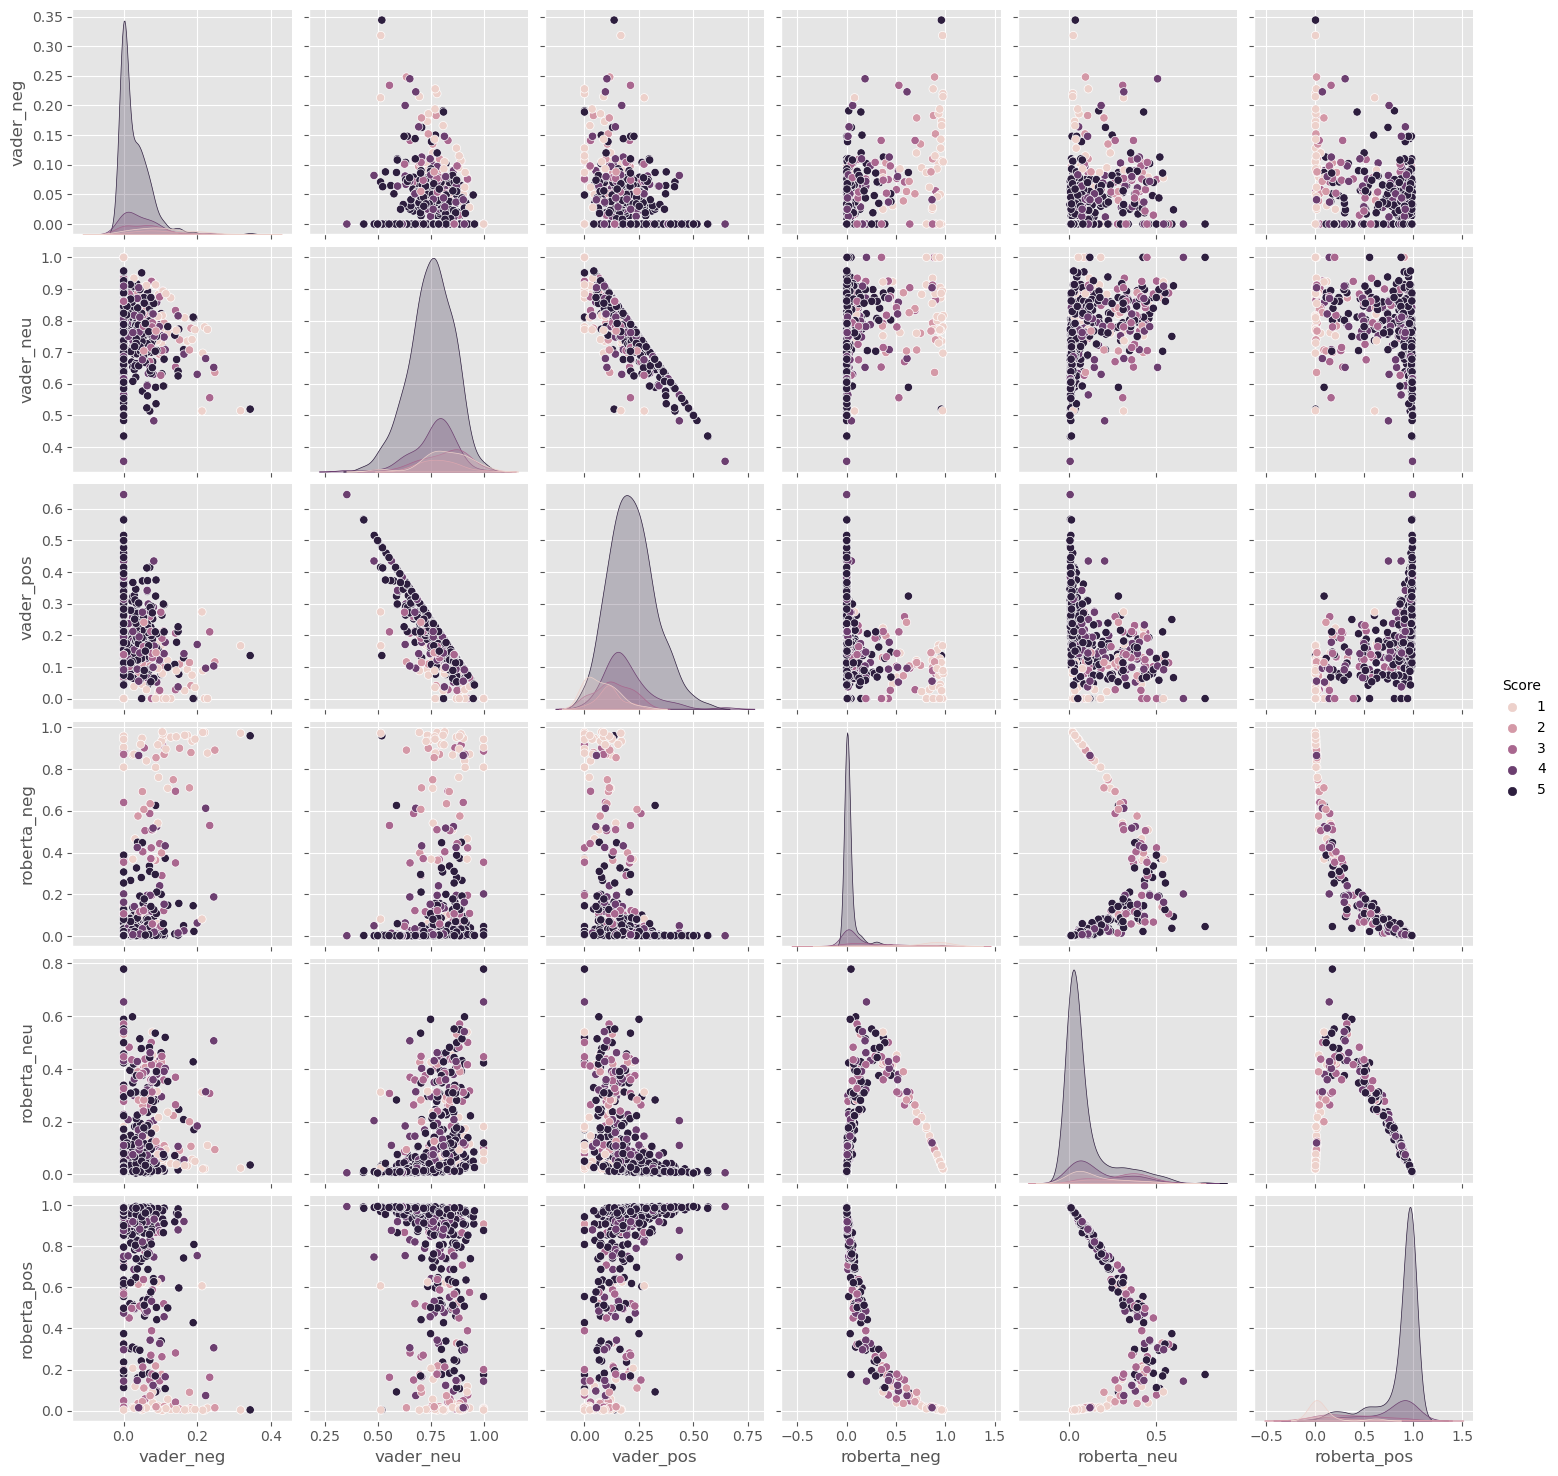

In [34]:
sns.pairplot(data=final_df, 
            vars=['vader_neg', 'vader_neu', 'vader_pos', 
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score')
plt.show()

**Roberta model exhibited a high kurtosis when compared to the VADER model. This indicates that the Roberta model is more confident in classifying sentiments.**

In [35]:
false_positives = final_df[(final_df.Score==1) & (final_df.roberta_pos>0.5)] \
    .sort_values('roberta_pos', ascending=False) \
    [['Score', 'Text', 'vader_pos', 'roberta_pos']]
false_positives

,Score,Text,vader_pos,roberta_pos
Id,,,,
255,1,"I felt energized within five minutes, but it l...",0.172,0.625637
209,1,"To me, these are nothing like the regular Alto...",0.130,0.621856
325,1,So we cancelled the order. It was cancelled w...,0.274,0.607180


In [36]:
for text in false_positives.Text: print(text, '\n')

I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money. 

To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness is just not strong, and the wintergreens are definitely weaker than the peppermint minis. I'm not a dragon-breath person, but still, one of these mints is too small to have any effect on my breath. Four or five will freshen my breath for a short while - maybe 15 minutes. At this point, I think the Icebreakers Frost mints are the best as sugar free breath mints. 

So we cancelled the order.  It was cancelled without any problem.  That is a positive note... 



**Findings:**
- All comments even though has 5 stars, is actually saracsting and negative than positive, so Roberta has managed to classified all of them correctly.

In [37]:
false_negatives = final_df[(final_df.Score==5) & (final_df.roberta_neg>0.5)] \
    .sort_values('roberta_neg', ascending=False) \
    [['Score', 'Text', 'vader_neg', 'roberta_neg']]
false_negatives

,Score,Text,vader_neg,roberta_neg
Id,,,,
70,5,this was sooooo deliscious but too bad i ate e...,0.344,0.960158
80,5,"i know i cannot make tea this good. granted, ...",0.087,0.626154


In [38]:
for text in false_negatives.Text: print(text, '\n')

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault 

i know i cannot make tea this good.  granted, i am not from the south but i know i have never enjoyed tea that was this sweet without being too sweet.  it tastes crisp. 



**Findings:**
- Both comments even though have 1 star, is more on the positive side, but Roberta failed to classify it correctly, and that too with a huge confident error of 96%. Here VADER has performed better in both situation.

In [39]:
True_positives = final_df[(final_df.Score==5) & (final_df.roberta_pos>0.5)] \
    .sort_values('roberta_pos', ascending=False) \
    [['Score', 'Text', 'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos']].head(5)
True_positives

,Score,Text,vader_neg,vader_neu,vader_pos,roberta_neg,roberta_neu,roberta_pos
Id,,,,,,,,
365,5,These are my favorite bars ever. The combo of ...,0.033,0.621,0.346,0.001597,0.004811,0.993591
453,5,This was the best deal ever. The delivery was ...,0.000,0.500,0.500,0.001787,0.004914,0.993299
155,5,AWESOME!!! such a yummy flavor I got it as a h...,0.000,0.647,0.353,0.001630,0.005390,0.992980
396,5,I appreciate the fact that I can buy this prod...,0.000,0.502,0.498,0.001319,0.006035,0.992647
333,5,I found these new spring Pop-Tarts and bought ...,0.000,0.689,0.311,0.001351,0.006339,0.992309


In [40]:
for text in True_positives.Text: print(text, '\n')

These are my favorite bars ever. The combo of raisons and dark choc is wonderful! Very filling! These are hard to find in the stores. I'm thankful for subsrcibe and save! 

This was the best deal ever. The delivery was fast, the chips are delicious and very fresh.  Love it:) 

AWESOME!!! such a yummy flavor I got it as a healthy alternative to the desserts we normally eat and I am so glad that I did there are so many things you can do with Jello desserts and still have them taste good and be good for you. I will definitentally be purchasing this product again the flavor was so wonderful. 

I appreciate the fact that I can buy this product online and have free shipping. This is a great all around mix that is very good with a wonderful texture. Thanks again amazon. 

I found these new spring Pop-Tarts and bought them on a whim.  My kids and I were amazed and delighted at the fun, colorful, amazingly detailed artwork on these Pop-Tarts.  Fantastic for after school snacks, lunch boxes, and

**Findings:**
- Even though all comments are full of positivity, the VADER's bag of words has failed to capure it.

In [41]:
True_negative = final_df[(final_df.Score==1) & (final_df.roberta_neg<0.5)] \
    .sort_values('roberta_neg', ascending=False) \
    [['Score', 'Text', 'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos']].head(5)
True_negative

,Score,Text,vader_neg,vader_neu,vader_pos,roberta_neg,roberta_neu,roberta_pos
Id,,,,,,,,
13,1,My cats have been happily eating Felidae Plati...,0.031,0.923,0.046,0.466125,0.415259,0.118616
217,1,"Hey, the description says 360 grams - that is ...",0.078,0.922,0.000,0.368826,0.539683,0.091491
165,1,Seriously this product was as tasteless as the...,0.025,0.752,0.223,0.368308,0.425197,0.206494
209,1,"To me, these are nothing like the regular Alto...",0.050,0.820,0.130,0.095904,0.282239,0.621856
325,1,So we cancelled the order. It was cancelled w...,0.213,0.514,0.274,0.081018,0.311802,0.607180


In [42]:
for text in True_negative.Text: print(text, '\n')

My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat. 

Hey, the description says 360 grams - that is roughly 13 ounces at under $4.00 per can. No way - that is the approximate price for a 100 gram can. 

Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor. 

To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness i

**Findings:**

- All comments are Negative, Both Roberta and VADER were inclined to classify it as neutral sentiments instead, while VADER being highly confident.

# Using Pipelines

In [43]:
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [44]:
sentiment_pipeline('How can I be good, if you are great?')

[{'label': 'POSITIVE', 'score': 0.9989858269691467}]